In [2]:
import networkx as nx
import scipy.linalg as linalg
import numpy as np
from sensors import utils, flows
import scipy.sparse as sparse
from tqdm.notebook import tqdm
import heapq

In [91]:
class RLSEvaluator(flows.lazy.LazyEvaluator):
    
    def evaluate(self, s):
        """
        Evaluate the benefit of adding sensor to current set (this.sensors).
        """
        j = self.T.index(s)
        
        S_j = sparse.identity(len(self.T), format="csr")
        idxs = list(set(range(S_j.shape[0])) - set([j]))
        S_j = S_j[idxs]
        S_j = sparse.csc_matrix(S_j)

        H_T = self.H_T @ S_j.T
        
        # Create trivial solution
        f0 = np.copy(self.f)
        np.put(f0, self.T, 0)
        f0[j] = self.f[s]
        
        # Create update matrices
        U = np.zeros((len(self.T), 2))
        U[j][0] = -1
        U[:, 1] = self.XTX[:, j].toarray().T[0]
        U[j][1] = 0
        
        V_T = np.zeros((2, len(self.T)))
        V_T[1][j] = -1
        V_T[0] = self.XTX[j].toarray()
        V_T[0][j] = 0
                
        Y = self.decomposition.solve(U)
        
        z = S_j.T @ (self.B @ H_T).T @ self.B @ f0.T
        z = self.decomposition.solve(z)
        
        V_T = sparse.csc_matrix(V_T)
        Y = sparse.csc_matrix(Y)
        f_hat = S_j @ (z - Y @ sparse.linalg.inv(sparse.identity(2) + V_T @ Y) @ V_T @ z)
#         f_hat = f_hat[:, 0]
        
#         f_hat_lsmr = sparse.linalg.lsmr(self.B @ H_T, (self.B @ f0.T).toarray(), damp=self.lam)[0]
#         print(np.linalg.norm(f_hat_lsmr - f_hat))

        f_T = self.f[np.ix_(self.T)]
        f_T = np.delete(f_T, self.T.index(s), 0)
        
        return np.linalg.norm(f_hat - f_T)
    
    def pop(self):
        # Current top 
        _, s = heapq.heappop(self.deltas)
        delta = self.evaluate(s) - self.current
            
        if len(self.deltas) == 0:
            self.sensors.append(s)
            return s, delta

        # Next top
        delta_next, s_next = heapq.heappop(self.deltas)
            
        # If the change drops it below the next best, recalculate the next best and continue
        while delta > delta_next:
            delta_next = self.evaluate(s_next) - self.current

            if delta_next <= delta:
                heapq.heappush(self.deltas, (delta, s))
                delta, s = delta_next, s_next
            else:
                heapq.heappush(self.deltas, (delta_next, s_next))
                
            delta_next, s_next = heapq.heappop(self.deltas)
            
        heapq.heappush(self.deltas, (delta_next, s_next))
        self.sensors.append(s)
           
        j = self.T.index(s)
        self.T.remove(s)
        
        idxs = list(set(range(self.H_T.shape[1])) - set([j]))
        self.H_T = self.H_T[:, idxs]
        
        self.XTX = sparse.csc_matrix(self.H_T.T @ self.B.T @ self.B @ self.H_T)
        self.decomposition = sparse.linalg.splu(self.XTX + self.lam * sparse.identity(len(self.T)))
        self.current += delta
                
        return s, delta
    
    def al_flows_greedy(self, ratio):
        k = int(ratio * len(self.labeled_edges))
        self.lam = 1e-6
        
        if k <= len(self.sensors):
            return self.sensors[:k]
        
        self.debug_print("calculating initial errors")
        
        # Create initial LU decomposition
        self.B = sparse.csc_matrix(nx.incidence_matrix(self.G, oriented=True))
        self.H_T = sparse.identity(self.G.number_of_edges(), format="csc")
        X = self.B @ self.H_T
        self.XTX = sparse.csc_matrix(X.T @ X)
        reg = sparse.csc_matrix(self.lam * np.identity(self.G.number_of_edges()))
        
        self.decomposition = sparse.linalg.splu(self.XTX + reg)
        
        # Initialize vector representations
        self.f = utils.metrics.dict2vect(self.G, self.labeled_edges)
        self.T = list(range(self.G.number_of_edges()))
        
        # Initial guess is 0, compute its error
        self.current = np.linalg.norm(np.zeros(self.G.number_of_edges()) - self.f)
        
        for e in tqdm(range(len(self.labeled_edges))):
            self.deltas.append((self.evaluate(e) - self.current, e))
            
        heapq.heapify(self.deltas)
        
        self.debug_print("choosing sensors")

        for i in tqdm(range(len(self.sensors), k)):
            s, delta = self.pop()
            self.debug_print("selected {} of {}, delta {}".format(i+1, k, delta))

        edges = list(self.G.edges())
        return [edges[i] for i in self.sensors]

In [32]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [93]:
evaluator = RLSEvaluator(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"))

%lprun -f evaluator.evaluate evaluator.al_flows_greedy(.01)

  0%|          | 0/2522 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


  0%|          | 0/25 [00:00<?, ?it/s]

In [100]:
import time

datasets = {"Anaheim": "data/Anaheim/Anaheim_flow.tntp",
            "Barcelona": "data/Barcelona/Barcelona_flow.tntp",
            "Chicago": "data/Chicago-Sketch/ChicagoSketch_flow.tntp",
            "Winnipeg": "data/Winnipeg/Winnipeg_flow.tntp",
           }

results = {"Lazy": [],
          "Lazy + Recursive": []
          }

for name, f in datasets.items():    
    # Time lazy
    t0 = time.time()
    evaluator = flows.lazy.LazyEvaluator(*utils.data.read_tntp_graph(f))
    evaluator.al_flows_greedy(.1)
    results["Lazy"].append(time.time() - t0) 
    
    # Time lazy + recursive
    t0 = time.time()
    evaluator = RLSEvaluator(*utils.data.read_tntp_graph(f))
    evaluator.al_flows_greedy(.1)
    results["Lazy + Recursive"].append(time.time() - t0)

100%|█████████████████████████████████████████████████████████████████| 91/91 [00:08<00:00, 11.26it/s]


  0%|          | 0/914 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


  0%|          | 0/91 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 252/252 [00:26<00:00,  9.43it/s]


  0%|          | 0/2522 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


  0%|          | 0/252 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 295/295 [00:27<00:00, 10.89it/s]


  0%|          | 0/2950 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


  0%|          | 0/295 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 283/283 [00:35<00:00,  8.03it/s]


  0%|          | 0/2836 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


  0%|          | 0/283 [00:00<?, ?it/s]

In [117]:
#     Time brute force, but only for Anaheim (rest too slow)
t0 = time.time()
evaluator = flows.bruteforce.BruteForceEvaluator(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"))
evaluator.al_flows_greedy(.1)
results["Brute Force"] = (time.time() - t0, 6000, 6000, 6000)

100%|█████████████████████████████████████████████████████████████████| 91/91 [15:40<00:00, 10.34s/it]


KeyError: 'Winnipeg'

In [123]:
results["Brute Force"] = (15 * 60 + 48, 3600, 3600, 3600)

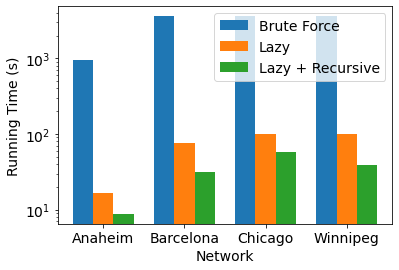

In [139]:
import matplotlib.pyplot as plt

x = np.arange(4)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()
cities = ("Anaheim", "Barcelona", "Chicago", "Winnipeg")

for alg, measurement in {a : results[a] for a in ["Brute Force", "Lazy", "Lazy + Recursive"]}.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=alg)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Running Time (s)', fontsize=14)
ax.set_xlabel('Network', fontsize=14)
ax.set_xticks(x + width, cities, fontsize=14)
ax.legend(loc='upper right', ncols=1, fontsize=14)
# ax.set_ylim(0, 3600)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_yscale("log")

plt.savefig("results/speedups.pdf")

## Correlation Plots

In [131]:
def normalize(f):
    return (1 / (max(f) - min(f))) * (f - np.full(len(f), min(f)))

In [132]:
evaluator = flows.lazy.LazyEvaluator(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"))
f = utils.metrics.dict2vect(evaluator.G, evaluator.labeled_edges)

greedy_sensors = evaluator.al_flows_greedy(.1)
f_greedy = utils.metrics.dict2vect(evaluator.G, evaluator.predict(greedy_sensors))

100%|█████████████████████████████████████████████████████████████████| 91/91 [00:06<00:00, 14.19it/s]


In [133]:
rb_sensors = evaluator.al_flows_rb(.1)
f_rb = utils.metrics.dict2vect(evaluator.G, evaluator.predict(rb_sensors))

In [134]:
rrqr_sensors = evaluator.al_flows_rrqr(.1, weighted=False)
f_rrqr = utils.metrics.dict2vect(evaluator.G, evaluator.predict(rrqr_sensors))

unweighted rrqr


In [135]:
max_sensors = evaluator.al_flows_max(.1)
f_max = utils.metrics.dict2vect(evaluator.G, evaluator.predict(max_sensors))

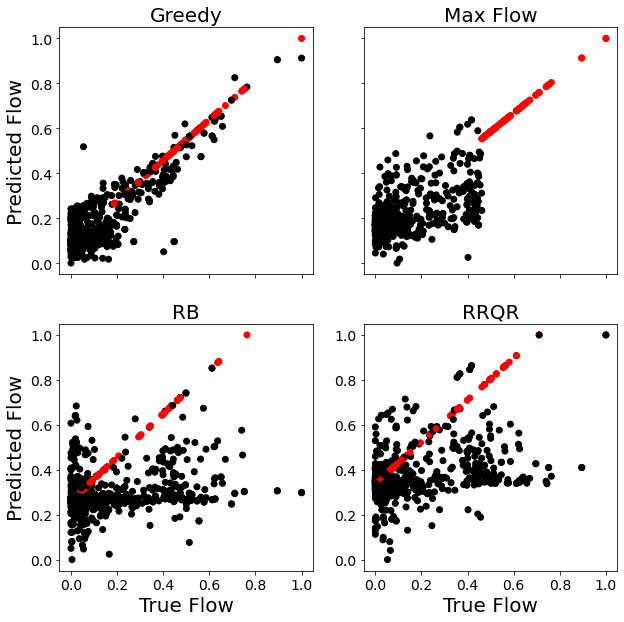

In [137]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0][0].scatter(normalize(f), normalize(f_greedy), c=["red" if e in greedy_sensors else "black" for e in evaluator.G.edges()])
ax[0][0].set_ylabel("Predicted Flow", fontsize=20)
ax[0][0].set_title("Greedy", fontsize=20)
ax[0][0].set_xticklabels([])

ax[0][1].scatter(normalize(f), normalize(f_max), c=["red" if e in max_sensors else "black" for e in evaluator.G.edges()])
ax[0][1].set_title("Max Flow", fontsize=20)
ax[0][1].set_xticklabels([])
ax[0][1].set_yticklabels([])

ax[1][0].scatter(normalize(f), normalize(f_rb), c=["red" if e in rb_sensors else "black" for e in evaluator.G.edges()])
ax[1][0].set_ylabel("Predicted Flow", fontsize=20)
ax[1][0].set_xlabel("True Flow", fontsize=20)
ax[1][0].set_title("RB", fontsize=20)

ax[1][1].scatter(normalize(f), normalize(f_rrqr), c=["red" if e in rrqr_sensors else "black" for e in evaluator.G.edges()])
ax[1][1].set_xlabel("True Flow", fontsize=20)
ax[1][1].set_title("RRQR", fontsize=20)
ax[0][1].set_yticklabels([])

plt.savefig("results/correlation_plots.pdf")

## Other Metrics

In [105]:
results = {}

for name, file in datasets.items():
    G, labeled_edges = utils.data.read_tntp_graph(file)
    m = max(labeled_edges.values())
    
    normalized_edges = {}
    for k, v in labeled_edges.items():
        normalized_edges[k] = v / m
    
    evaluator = flows.lazy.LazyEvaluator(G, normalized_edges)
    
    f = utils.metrics.dict2vect(evaluator.G, evaluator.labeled_edges)
    
    greedy_sensors = evaluator.al_flows_greedy(.1)
    f_greedy = utils.metrics.dict2vect(evaluator.G, evaluator.predict(greedy_sensors))
    
    rb_sensors = evaluator.al_flows_rb(.1)
    f_rb = utils.metrics.dict2vect(evaluator.G, evaluator.predict(rb_sensors))
    
    rrqr_sensors = evaluator.al_flows_rrqr(.1, weighted=False)
    f_rrqr = utils.metrics.dict2vect(evaluator.G, evaluator.predict(rrqr_sensors))
    
    max_sensors = evaluator.al_flows_max(.1)
    f_max = utils.metrics.dict2vect(evaluator.G, evaluator.predict(max_sensors))
    
    rand_sensors = evaluator.al_flows_random(.1)
    f_rand = utils.metrics.dict2vect(evaluator.G, evaluator.predict(rand_sensors))
    
    dataset = {}
    for alg, f_ in zip(["Greedy", "Max", "RB", "RRQR", "Random"], [f_greedy, f_max, f_rb, f_rrqr, f_rand]):
        # Correlation, MSE, MAE, MAPE, Max Error
        res = {}
        
        res["Correlation"] = np.corrcoef(f, f_)[0][1]
        res["MSE"] = 1 / len(f) * np.linalg.norm(f - f_) ** 2
        res["MAE"] = 1 / len(f) * sum([abs(s - s_) for s, s_ in zip(f, f_)])
        res["MAPE"] = 100 / len(f) * sum([abs((s - s_) / s) if s != 0 else 0 for s, s_ in zip(f, f_)])
        res["Max Error"] = max(f - f_)
        
        dataset[alg] = res
    
    results[name] = dataset

100%|███████████████████████████████████████████████████████████████| 283/283 [00:32<00:00,  8.76it/s]


In [106]:
results

{'Anaheim': {'Greedy': {'Correlation': 0.9359204480845851,
   'MSE': 0.005595586782800234,
   'MAE': 0.05122695793680473,
   'MAPE': 194.38104864338905,
   'Max Error': 0.45230309550480907},
  'Max': {'Correlation': 0.8524342911077664,
   'MSE': 0.013640178099664037,
   'MAE': 0.07550678369262286,
   'MAPE': 264.4982431667357,
   'Max Error': 0.5765550684276488},
  'RB': {'Correlation': 0.40162178853707226,
   'MSE': 0.04296783705144059,
   'MAE': 0.13001798049546026,
   'MAPE': 209.27684583061102,
   'Max Error': 0.9633589084924393},
  'RRQR': {'Correlation': 0.49265612217631993,
   'MSE': 0.038195542926799934,
   'MAE': 0.12098093010641553,
   'MAPE': 246.38834704286333,
   'Max Error': 0.817650517419751},
  'Random': {'Correlation': 0.49030153497724127,
   'MSE': 0.03888629276930459,
   'MAE': 0.12269472433686007,
   'MAPE': 310.0327758293605,
   'Max Error': 0.9721778946602481}},
 'Barcelona': {'Greedy': {'Correlation': 0.8685368283877068,
   'MSE': 0.007810414012162315,
   'MAE': 